STAT 451: Machine Learning (Fall 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat451-fs2020/

# L10: Model Evaluation 3 -- Cross-Validation and Model Selection

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Sebastian Raschka 
last updated: 2020-11-20 

CPython 3.8.2
IPython 7.18.1

numpy 1.18.5
mlxtend 0.18.0.dev0
matplotlib 3.3.1
sklearn 0.23.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

<p style="margin-bottom:5cm;"></p>


## K-fold and standard deviation (1-standard error method)

- Below is an application of the 1-standard error method we discussed in class (to select hyperparameters according to the "Law of Parsimony")

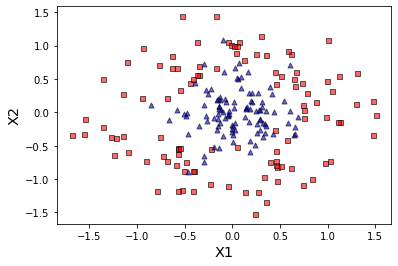

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles


X, y = make_circles(n_samples=300, random_state=1, noise=0.275, factor=0.2)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=12345,
                                                    stratify=y)

plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
            marker='s', color='red', edgecolor='k', alpha=0.6, s=25)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
            marker='^', color='blue', edgecolor='k', alpha=0.6, s=25)
plt.xlabel('X1', fontsize=14.5)
plt.ylabel('X2', fontsize=14.5)

plt.show()

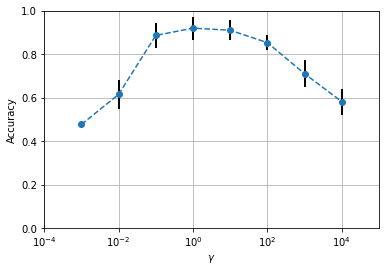

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape='ovo', 
              random_state=0)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

## PLOTTING

ax = plt.subplot(111)
ax.set_xscale('log')
ax.errorbar(params, cv_acc, yerr=cv_std, fmt='--o', ecolor='black', elinewidth=2)


plt.ylim([0.0, 1.0])
plt.xlim([0.0001, 100000.0])
plt.grid()
plt.xlabel('$\\gamma$')
plt.ylabel('Accuracy')
plt.show()

<p style="margin-bottom:5cm;"></p>

- Below is a visualization of the decision boundary of the "most parsimonious" hyperparameter choice

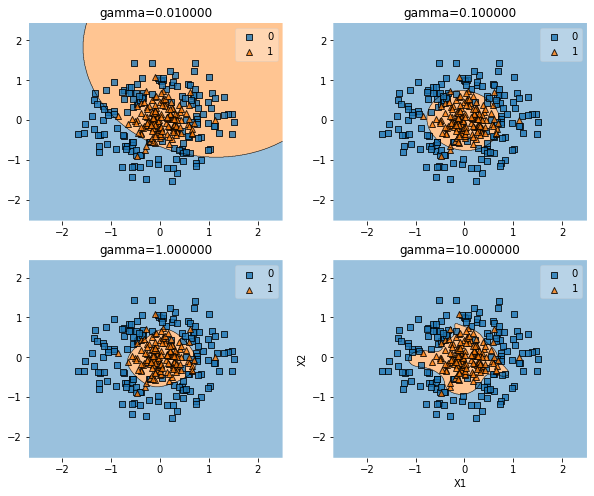

In [5]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


gspec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for c, grd in zip([0.01, 0.1, 1.0, 10.], itertools.product([0, 1], repeat=2)):

    clf = SVC(C=10.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape='ovo', 
              random_state=0)

    clf.fit(X_train, y_train)
    ax = plt.subplot(gspec[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title('gamma=%f' % c)


plt.xlabel('X1') 
plt.ylabel('X2')

plt.show()

<p style="margin-bottom:5cm;"></p>

- The following cells in this section repeat the procedure of choosing the most parsimonious hyperparameter using decision trees and two features of the Iris dataset (petal length and petal width)

In [6]:
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)


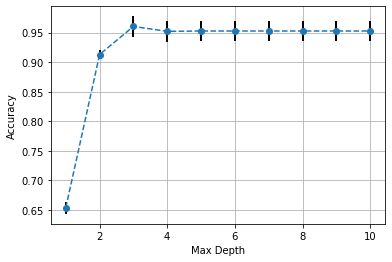

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold


params = range(1, 11)
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for c in params:

    clf = DecisionTreeClassifier(random_state=123, max_depth=c)

    
    all_acc = []
    for train_index, valid_index in cv.split(X_train, y_train):
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

## PLOTTING

ax = plt.subplot(111)
ax.errorbar(params, cv_acc, yerr=cv_stderr, fmt='--o', ecolor='black', elinewidth=2)


plt.grid()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

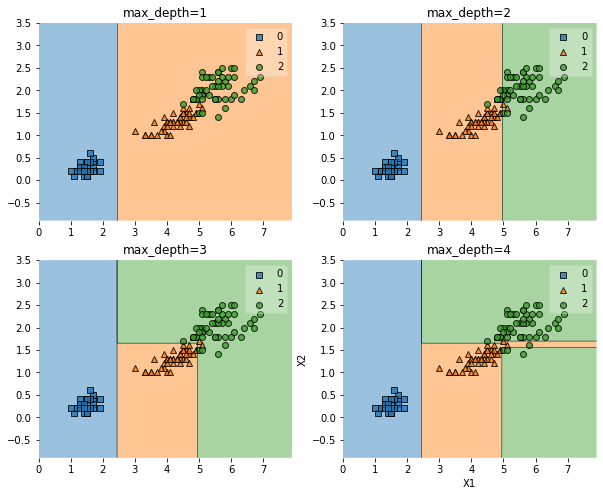

In [8]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


gspec = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for c, grd in zip([1, 2, 3, 4], itertools.product([0, 1], repeat=2)):

    clf = DecisionTreeClassifier(random_state=123, max_depth=c)

    clf.fit(X_train, y_train)
    ax = plt.subplot(gspec[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title('max_depth=%d' % c)


plt.xlabel('X1') 
plt.ylabel('X2')

plt.show()